### Imports

In [113]:
import sys

import matplotlib.pyplot as plt
import json

import numpy as np
import pandas as pd

# import dysts
# from dysts.flows import *
from dysts.base import *
# from dysts.utils import *
# from dysts.analysis import *

import degas as dg
dg.set_style()

import seaborn as sns
sns.set_style()

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Make training data

In [ ]:
import sys
import json
import os
import numpy as np


from dysts.base import get_attractor_list
from dysts.analysis import sample_initial_conditions
import dysts.flows

n_train = 150

all_train_test = dict()
for i, equation_name in enumerate(get_attractor_list()):
    
    all_train_test[equation_name] = dict()
    model = getattr(dysts.flows, equation_name)()
    
    np.random.seed(0)
    ic_train, ic_test = sample_initial_conditions(model, 2, traj_length=1000, pts_per_period=30)
    
    model.ic = ic_train
    tvals, sol = model.make_trajectory(n_train, pts_per_period=15, resample=True, return_times=True, standardize=False)
    dt = np.median(np.diff(tvals))
    dsol = np.vstack([model.rhs(val, 0) for val in sol])# * dt
    X_train, y_train = sol, dsol
    t_train = tvals

    model.ic = ic_test
    tvals, sol = model.make_trajectory(n_train, pts_per_period=15, resample=True, return_times=True, standardize=False)
    dt = np.median(np.diff(tvals))
    dsol = np.vstack([model.rhs(val, 0) for val in sol])# * dt
    X_test, y_test = sol, dsol
    t_test = tvals
    
    all_train_test[equation_name]["X_train"] = X_train.tolist()
    all_train_test[equation_name]["X_test"] = X_test.tolist()
    all_train_test[equation_name]["y_train"] = y_train.tolist()
    all_train_test[equation_name]["y_test"] = y_test.tolist()
    all_train_test[equation_name]["t_train"] = t_train.tolist()
    all_train_test[equation_name]["t_test"] = t_test.tolist()
    
    np.any(np.isnan(X_test)) or np.any(np.isnan(X_train))
    
# with open("./resources/symb_train_test_data.json", 'w') as file:
#     json.dump(all_train_test, file, indent=4)

# Run experiments

These benchmarks require [dsr](https://github.com/brendenpetersen/deep-symbolic-optimization) and [pySR](https://github.com/MilesCranmer/PySR)

In [5]:
%%bash

python3 symbolic_regression_benchmarks.py

# Analyze results

In [5]:
import dysts.flows

attributes = [
    "maximum_lyapunov_estimated",
    "kaplan_yorke_dimension",
    "multiscale_entropy",
    "correlation_dimension",
]
all_properties = dict()
for equation_name in get_attractor_list():
    eq = getattr(dysts.flows, equation_name)()
    attr_vals = [getattr(eq, item, None) for item in attributes]

    all_properties[equation_name] = dict(zip(attributes, attr_vals))

all_properties = pd.DataFrame(all_properties).transpose().dropna()

In [6]:
# get data
with open("results/symbolic_scores_sweep.json", "r") as file:
    data = json.load(file)

data = pd.DataFrame(data).transpose()
data_reduced = data[["pySR", "DSR", "SINDY-poly", "SINDY-fourier"]]

## print timing information
print(data[["pySR-time", "DSR-time", "SINDY-poly-time", "SINDY-fourier-time"]].median())
print(
    1.253
    * data[["pySR-time", "DSR-time", "SINDY-poly-time", "SINDY-fourier-time"]].sem()
)

pySR-time             1405.186874
DSR-time              4332.729651
SINDY-poly-time          0.012598
SINDY-fourier-time       0.013998
dtype: float64
pySR-time              58.078007
DSR-time              248.490689
SINDY-poly-time         0.012836
SINDY-fourier-time      0.002041
dtype: float64


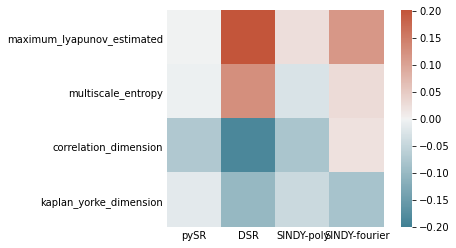

In [36]:
cross_corr = (
    pd.concat(
        [data_reduced, all_properties], axis=1, keys=["data_reduced", "all_properties"]
    )
    .corr(method="spearman")
    .loc["data_reduced", "all_properties"]
)
math_sort_inds = np.argsort(np.max(cross_corr, axis=0))[::-1]

vspan = np.max(np.abs(np.array(cross_corr)))
ax = sns.heatmap(
    cross_corr.transpose().iloc[math_sort_inds, :],
    cmap=sns.diverging_palette(220, 20, as_cmap=True),
    vmin=-vspan,
    vmax=vspan,
)
ax.set_aspect(1)
ax.tick_params(axis="both", which="both", length=0)

# dg.better_savefig("../private_writing/fig_resources/symbolic_metric_correlations.png", dpi=600)

### Make violin plots

In [90]:
model_names = ['pySR', 'DSR', 'SINDY-poly', 'SINDY-fourier']


def mirror_df(df, mirror_val=0):
    """
    Create a mirrored augmented dataframe. Used
    for setting the right boundary conditions on kernel 
    density plots
    """
    return pd.concat([df, mirror_val - df])

data_flip = mirror_df(data)


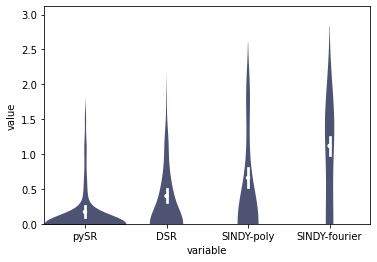

In [92]:


data_long = pd.melt(data_flip, value_vars=model_names)
ax = sns.violinplot(data=data_long,  x="variable", y="value",  
              linewidth=0, size=3, alpha=0.1, split=True, 
                    width=1,
                    order=model_names,
                    scale="area", inner=None, 
                    color=[71/255., 78/255., 123/255.],
                   )

data_long = pd.melt(data, value_vars=model_names)
ax = sns.pointplot(data=data_long, x="variable", y="value", 
                   order=model_names,
              linewidth=0, 
                   size=0.1, 
                   scale = 0.5,
                   palette={ "w"}, 
                   join=False, ci=99)

plt.ylim([0, None])

dg.fixed_aspect_ratio(1/1.5)

# dg.better_savefig("../private_writing/fig_resources/symbolic_violins.png", dpi=600)

<AxesSubplot:>

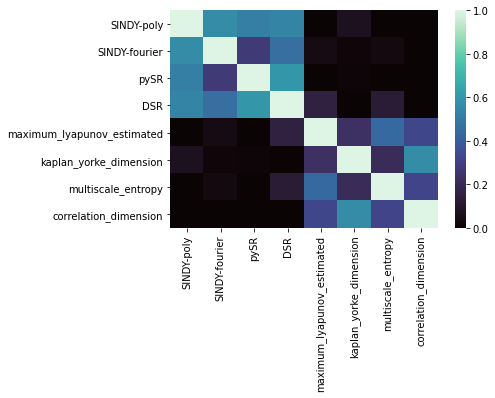

In [82]:
all_properties = dict()
model_names = ["SINDY-poly", "SINDY-fourier", "pySR", "DSR"]
attributes = [
    "maximum_lyapunov_estimated",
    "kaplan_yorke_dimension",
    "multiscale_entropy",
    "correlation_dimension",
]
for equation_name in data.index:
    eq = getattr(dysts.flows, equation_name)()
    attr_vals = [getattr(eq, item, None) for item in attributes]

    all_properties[equation_name] = dict(zip(attributes, attr_vals))
all_properties = pd.DataFrame(all_properties).transpose()

data_aug = pd.merge(
    data, all_properties, how="outer", left_index=True, right_index=True
)


sns.heatmap(
    data_aug[model_names + attributes].corr(method="spearman"),
    vmin=0,
    vmax=1,
    cmap="mako",
)

# dg.fixed_aspect_ratio(1)

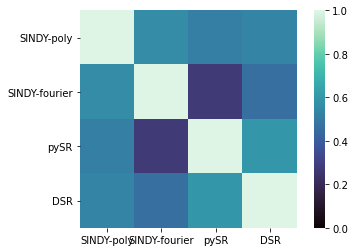

In [87]:
import seaborn as sns

ax = sns.heatmap(data[model_names].corr(method="spearman"), cmap="mako", vmin=0, vmax=1)

ax.set_aspect('equal')

# dg.better_savefig("../private_writing/fig_resources/symbolic_corr.png", dpi=600)

In [18]:
all_lowest_scores = np.min(all_vals, axis=1)
np.array(list(data.keys()))[np.argsort(all_lowest_scores)]

array(['SprottO', 'SprottN', 'Colpitts', 'SprottMore', 'ScrollDelay',
       'ShimizuMorioka', 'SprottA', 'SprottJerk', 'SprottC', 'SprottJ',
       'SprottH', 'ForcedVanDerPol', 'SprottF', 'SprottE', 'SprottDelay',
       'HyperLu', 'HyperLorenz', 'SprottI', 'SprottP', 'SprottB',
       'ItikBanksTumor', 'NewtonLiepnik', 'Arneodo', 'VallisElNino',
       'MooreSpiegel', 'MackeyGlass', 'ChenLee', 'RikitakeDynamo',
       'Laser', 'SprottR', 'LuChen', 'HastingsPowell', 'SprottD',
       'SaltonSea', 'KawczynskiStrizhak', 'RayleighBenard', 'Rossler',
       'LiuChen', 'SprottG', 'SprottQ', 'HyperRossler', 'WangSun',
       'HyperQi', 'ArnoldBeltramiChildress', 'PanXuZhou', 'Hopfield',
       'Chen', 'CellularNeuralNetwork', 'Rucklidge', 'Bouali',
       'AnishchenkoAstakhov', 'HyperYan', 'HyperYangChen',
       'PiecewiseCircuit', 'HyperWang', 'StickSlipOscillator', 'Tsucs2',
       'ExcitableCell', 'SprottS', 'OscillatingFlow', 'HyperJha',
       'SprottM', 'WindmiReduced', 'LorenzBound

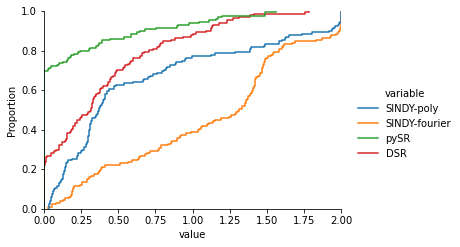

In [192]:
data_long = pd.melt(data, value_vars=model_names)
# sns.displot(data_long, x="value", hue="variable", multiple="stack", kind="kde")
# sns.displot(data_long, x="value", hue="variable", kind="kde", fill=True)
sns.displot(data_long, x="value", hue="variable", kind="ecdf")
plt.xlim([-1e-8, 2])

dg.fixed_aspect_ratio(1/1.5)

## Plot easiest, hardest, and median attractors

In [79]:
sorted_medscores = data_reduced.median(axis=1).sort_values()
print(sorted_medscores.index[0])
print(sorted_medscores.index[len(sorted_medscores) // 2])
print(sorted_medscores.index[-1])

GenesioTesi
YuWang2
Torus


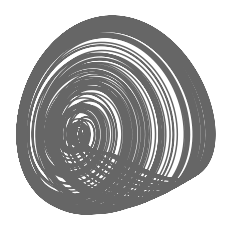

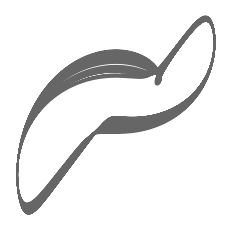

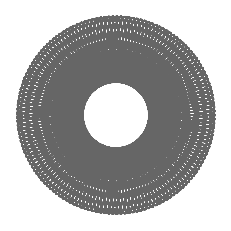

In [80]:
from dysts.flows import GenesioTesi, YuWang2, Torus

style1 = {"color": (0.4, 0.4, 0.4)}

plt.figure()
sol = GenesioTesi().make_trajectory(50000, resample=True, pts_per_period=400)
plt.plot(sol[:, 0], sol[:, 1], **style1)
dg.fixed_aspect_ratio(1)
dg.vanish_axes()
# dg.better_savefig("../private_writing/fig_resources/sprott_torus.png", dpi=600)


plt.figure()
sol = YuWang2().make_trajectory(50000, resample=True, pts_per_period=400)
plt.plot(sol[:, 0], sol[:, 1], **style1)
dg.fixed_aspect_ratio(1)
dg.vanish_axes()
# dg.better_savefig("../private_writing/fig_resources/stickslip.png", dpi=600)


plt.figure()
sol = Torus().make_trajectory(50000, resample=True, pts_per_period=400)
plt.plot(sol[:, 0], sol[:, 1], **style1)
dg.fixed_aspect_ratio(1)
dg.vanish_axes()
# dg.better_savefig("../private_writing/fig_resources/torus.png", dpi=600)

### Correlate forecast ability with symbolic scores

In [133]:
import os
import json

with open(
    os.getcwd()
    + "/results/results_test_univariate__pts_per_period_100__periods_12.json",
    "r",
) as file:
    all_results = json.load(file)

all_best_results = dict()
for equation_name in all_results:
    all_results[equation_name].keys()

    all_smape_values = list()
    for model_name in all_results[equation_name].keys():
        if model_name == "values":
            continue
        all_smape_values.append(all_results[equation_name][model_name]["smape"])

    all_best_results[equation_name] = np.min(all_smape_values)

In [138]:
symb_series, forecast_series = (
    pd.DataFrame(data_reduced.min(axis=1)),
    pd.DataFrame(pd.Series(all_best_results)),
)

cross_corr = (
    pd.concat(
        [symb_series, forecast_series], axis=1, keys=["symb_series", "forecast_series"]
    )
    .corr(method="spearman")
    .loc["symb_series", "forecast_series"]
)
print(cross_corr)
math_sort_inds = np.argsort(np.max(cross_corr, axis=0))[::-1]

# ax = sns.heatmap(cross_corr.transpose().iloc[math_sort_inds, metric_sort_inds], cmap="mako", vmin=0, vmax=1)
# ax.set_aspect(1)
# ax.tick_params(axis='both', which='both', length=0)

          0
0 -0.164494
